# Car Detection using YOLO model

<a name='0'></a>
## Packages

Run the following cell to load the packages and dependencies that will come in handy as you build the object detector!

In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image

%matplotlib inline

## YOLO Model

### Filtering with a Threshold on Class Scores

In [2]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    
    box_scores = box_confidence*box_class_probs

    
    box_classes = tf.math.argmax(box_scores,axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores,axis=-1,keepdims = False)
    
    
    filtering_mask = (box_class_scores>=threshold)
    
    
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    
    return scores, boxes, classes

### Finding Intersection over Union(IOU)

In [3]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """


    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    
    xi1 = np.maximum(box1[0],box2[0])
    yi1 = np.maximum(box1[1],box2[1])
    xi2 = np.minimum(box1[2],box2[2])
    yi2 = np.minimum(box1[3],box2[3])
    inter_width = xi2-xi1
    inter_height =  yi2-yi1
    inter_area = max(inter_width,0)*max(inter_height,0)
    
    
    box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
    box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
    union_area = box1_area + box2_area - inter_area
    
    
    iou = float(inter_area)/float(union_area)
    
    return iou

### Applying Non-Max Suppression

In [4]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')    

    
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=max_boxes, iou_threshold=iou_threshold)
    
    
    scores = tf.gather(scores,nms_indices)
    boxes = tf.gather(boxes,nms_indices)
    classes = tf.gather(classes,nms_indices)
    

    
    return scores, boxes, classes

In [5]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  
        box_mins[..., 0:1],
        box_maxes[..., 1:2], 
        box_maxes[..., 0:1]  
    ])


### Yolo_eval

In [6]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
   
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    
    boxes = yolo_boxes_to_corners(box_xy,box_wh)
    
    
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = score_threshold)
    
    
    boxes = scale_boxes(boxes,image_shape)
    
    
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes, iou_threshold = iou_threshold)
    
    
    return scores, boxes, classes

### Defining Classes, Anchors and Image Shape

In [7]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608)

### Loading a Pre-trained Model

In [8]:
from tensorflow.keras.models import load_model

In [9]:
yolo_model = load_model("model_data/", compile=False)


In [10]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 608, 608, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 608, 608, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 608, 608, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 608, 608, 32)         0         ['batch_normalizati

 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)   (None, 38, 38, 512)          0         ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 38, 38, 256)          131072    ['leaky_re_lu_8[0][0]']       
                                                                                                  
 batch_normalization_9 (Bat  (None, 38, 38, 256)          1024      ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_

 tchNormalization)                                                                                
                                                                                                  
 conv2d_20 (Conv2D)          (None, 38, 38, 64)           32768     ['leaky_re_lu_12[0][0]']      
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)  (None, 19, 19, 1024)         0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_20 (Ba  (None, 38, 38, 64)           256       ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_19

### Predicting boxes around Cars

In [11]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
   
    colors = get_colors_for_classes(len(class_names))
    
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    
    image.save(os.path.join("out", image_file), quality=100)
    
    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Run the following cell on the "test.jpg" image to verify that your function is correct.

Found 10 boxes for images/OIP.jpg
car 0.86 (259, 118) (312, 163)
car 0.79 (138, 32) (157, 46)
car 0.77 (69, 51) (90, 70)
car 0.75 (11, 147) (65, 204)
car 0.71 (184, 94) (224, 128)
car 0.71 (110, 139) (163, 195)
car 0.68 (36, 93) (72, 123)
car 0.63 (115, 45) (137, 63)
car 0.62 (112, 23) (125, 36)
car 0.61 (185, 39) (204, 55)


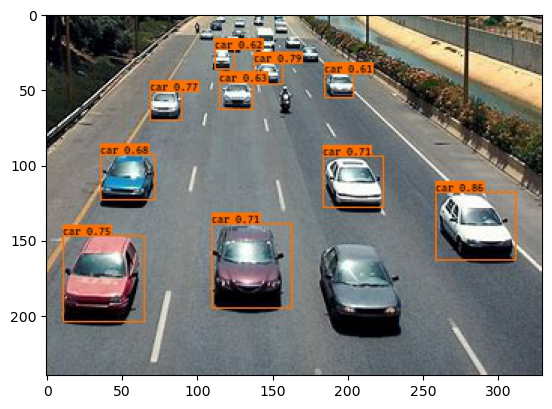

In [14]:
out_scores, out_boxes, out_classes = predict("OIP.jpg")